<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Timeseries/Household_power_consumption_multivariate_multistep_inbuildnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Household Power Consumption Dataset**
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

global_active_power: The total active power consumed by the household (kilowatts).

global_reactive_power: The total reactive power consumed by the household (kilowatts).

voltage: Average voltage (volts).

global_intensity: Average current intensity (amps).

sub_metering_1: Active energy for kitchen (watt-hours of active energy).

sub_metering_2: Active energy for laundry (watt-hours of active energy).

sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current.

In general terms, the active energy is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

We can see that the dataset provides the active power as well as some division of the active power by main circuit in the house, specifically the kitchen, laundry, and climate control. These are not all the circuits in the household.

The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

# Imports

In [8]:
import urllib
import os
import zipfile
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import zipfile


# [Optional] Copy data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir data
!cp '/content/drive/MyDrive/Data Science & Machine Learning/Tensorflow Certification/Repository/Tensorflow_projects/Data/Household Power Consumption/cleaned/household_power_consumption.csv' './data/'

mkdir: cannot create directory ‘data’: File exists


# Helper Function

In [9]:
# Auxiliary plotting function
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [10]:
# Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):

	scores = []

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):

		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])

		# calculate rmse
		rmse = sqrt(mse)

		# store the rmse in list
		scores.append(rmse)

	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):

			s = s + (actual[row, col] - predicted[row, col])**2
	overall_score = sqrt(s / (actual.shape[0] * actual.shape[1]))

	return overall_score, scores

In [11]:
from numpy import nan

# fill missing values with a value at the same time one day ago
def fill_missing(values):
  one_day = 60 * 24 #granulatiy of data is minutes
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row, col]):
        print("replacing missing value of ",values[row, col],"at position [",row, col,"] with :",values[row - one_day, col])
        values[row, col] = values[row - one_day, col] #if given day has 'nan' , then replace the value with previous day's reading

# Data Insights

 Download Data Set: UCI Machine Learning repository as a single 20 megabyte .zip file:

[household_power_consumption.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip)


In [12]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2024-04-13 23:22:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [    <=>             ]  19.68M  23.9MB/s    in 0.8s    

2024-04-13 23:22:37 (23.9 MB/s) - ‘household_power_consumption.zip’ saved [20640916]



In [13]:
zip_ref = './household_power_consumption.zip'
datafile = "./data/household_power_consumption.txt"

file = zipfile.ZipFile(zip_ref, 'r')
file.extractall('./data')
file.close()

In [14]:
df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)

<ipython-input-14-6f90a0c86db3>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)
<ipython-input-14-6f90a0c86db3>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(datafile, sep=';', infer_datetime_format=True, index_col='datetime', parse_dates={'datetime':[0,1]}, header=0, low_memory=False)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [16]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


# Data Transformation

## Missing data

In [17]:
from numpy import nan

# # mark all missing values
df.replace('?', nan, inplace=True)

# make dataset numeric
df = df.astype('float32')

Check if any values are missing

In [18]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill_missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [ ]:
from math import isnan

# fill missing
fill_missing(df.values)

Streaming output truncated to the last 5000 lines.
replacing missing value of  nan at position [ 1311750 0 ] with : 0.388
replacing missing value of  nan at position [ 1311750 1 ] with : 0.086
replacing missing value of  nan at position [ 1311750 2 ] with : 241.9
replacing missing value of  nan at position [ 1311750 3 ] with : 1.6
replacing missing value of  nan at position [ 1311750 4 ] with : 0.0
replacing missing value of  nan at position [ 1311750 5 ] with : 0.0
replacing missing value of  nan at position [ 1311750 6 ] with : 0.0
replacing missing value of  nan at position [ 1311751 0 ] with : 0.39
replacing missing value of  nan at position [ 1311751 1 ] with : 0.086
replacing missing value of  nan at position [ 1311751 2 ] with : 241.93
replacing missing value of  nan at position [ 1311751 3 ] with : 1.6
replacing missing value of  nan at position [ 1311751 4 ] with : 0.0
replacing missing value of  nan at position [ 1311751 5 ] with : 0.0
replacing missing value of  nan at posit

Now we can create a new column that contains the remainder of the sub-metering, using the calculation from the previous section.The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

In [ ]:
# add a column for for the remainder of sub metering
values = df.values
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6]) #this operation can only be done using series

## Convert data to daily grain

As we notice here , data here is in hourly grain. We should transform the data to daily grain in order to be able to make daily forecasts.

In [ ]:
#resample data to daily
daily_groups = df.resample('D') #D=daily
print(daily_groups)

In [ ]:
dailyDF = daily_groups.sum()

# summarize
print(dailyDF.shape)
display(dailyDF.head())

# Data Normalization

In [103]:
data = np.array(dailyDF)

In [104]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(data) #should only be adapted on training data

In [7]:
normalizer(data).mean()
normalizer(data).std()

NameError: name 'normalizer' is not defined

# Training - Validation Split

We will use the first three years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday.

This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted. It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.

We will split the data into standard weeks, working backwards from the test dataset.

In [106]:
print(dailyDF)

            Global_active_power  Global_reactive_power       Voltage  \
datetime                                                               
2006-12-16          1209.176025              34.922001   93552.53125   
2006-12-17          3390.459961             226.005997  345725.31250   
2006-12-18          2203.825928             161.792007  347373.62500   
2006-12-19          1666.193970             150.942001  348479.00000   
2006-12-20          2225.748047             160.998001  348923.62500   
...                         ...                    ...           ...   
2010-11-22          2041.536011             142.354004  345883.84375   
2010-11-23          1577.536011             137.449997  346428.75000   
2010-11-24          1796.248047             132.460007  345644.59375   
2010-11-25          1431.163940             116.127998  347812.21875   
2010-11-26          1488.104004             120.826004  303487.56250   

            Global_intensity  Sub_metering_1  Sub_metering_2  S

As we can see, the last record in data is of 2010-11-26. Assuming the week starts as Sunday. So, let's try to pull earliest data of 2010 year in Sunday which is 2010-01-03. This is our testing set.

All remaining data i.e, 2006-12-16 till 2010-01-02 is our training data.

In [107]:
# Number of features in the dataset. We use all features as predictors to predict all features of future time steps.
num_features = len(dailyDF.columns)

In [113]:
series_val = dailyDF["2010-01-03":"2010-11-26"]
series_train = dailyDF["2006-12-16":"2010-01-02"]

# Global Parameters

In [119]:
# Hyper-Parameters
BATCH_SIZE = 32 # Batch size
N_PAST = 7 # Number of past time steps based on which future observations should be predicted
N_FUTURE = 7 # Number of future time steps which are to be predicted.
SHIFT = 1 # By how many positions the window slides to create a new window of observations.

# Batching of dataset

In [120]:

# This is multi step prediction.
# window size = n_past + n_future
# n_past --> no. of previous observations used to make forecast
# n_future --> horizon for which we make forecast

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))

    # Create tuples with features and labels
    ds = ds.map(lambda w: (w[:n_past], w[n_past:])) #(window[:-1], window[-1])

    # Create batches of windows
    dataset = ds.batch(batch_size).prefetch(1)

    return dataset

In [121]:
# Windowed train and validation datasets.
train_set = windowed_dataset(series_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
valid_set = windowed_dataset(series_val, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

In [122]:
# Print the data shape
for window in train_set.take(1):
    print(f'Shape of feature: {window[0].shape}')
    print(f'Shape of label: {window[1].shape}')

Shape of feature: (32, 7, 8)
Shape of label: (32, 7, 8)


# Global Parameters

In [ ]:
# Hyper-Parameters
BATCH_SIZE = 32 # Batch size
N_PAST = 10 # Number of past time steps based on which future observations should be predicted
N_FUTURE = 10 # Number of future time steps which are to be predicted.
SHIFT = 1 # By how many positions the window slides to create a new window of observations.

# Batching of dataset

In [ ]:

# This is multi step prediction.
# window size = n_past + n_future
# n_past --> no. of previous observations used to make forecast
# n_future --> horizon for which we make forecast

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))

    # Create tuples with features and labels
    ds = ds.map(lambda w: (w[:n_past], w[n_past:])) #(window[:-1], window[-1])

    # Create batches of windows
    dataset = ds.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Windowed train and validation datasets.
train_set = windowed_dataset(series_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
valid_set = windowed_dataset(series_val, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

In [ ]:
# Print the data shape
for window in train_set.take(1):
    print(f'Shape of feature: {window[0].shape}')
    print(f'Shape of label: {window[1].shape}')

Shape of feature: (32, 10, 48)
Shape of label: (32, 10, 48)


# Build Model

In [123]:
# Code to define your model.
inputs = tf.keras.layers.Input(shape=[N_PAST, num_features])
x = normalizer(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
#tf.keras.layers.Dropout(0.2),
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
#tf.keras.layers.Dropout(0.2),
x = tf.keras.layers.Dense(num_features* N_FUTURE)(x)
outputs = tf.keras.layers.Reshape([N_FUTURE, num_features])(x)

model = tf.keras.Model(inputs,outputs)

# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 8)]            0         
                                                                 
 normalization (Normalizati  (None, 7, 8)              17        
 on)                                                             
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            140288    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 128)            164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                       

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [124]:
#Get initial weights
init_weights = model.get_weights()

In [126]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch/20))

# Initialize the optimizer
optimizer=tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
35/35 [==============================] - 15s 58ms/step - loss: 47398.1992 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 2s 51ms/step - loss: 47398.1836 - lr: 0.0011
Epoch 3/100
35/35 [==============================] - 2s 48ms/step - loss: 47398.1680 - lr: 0.0013
Epoch 4/100
35/35 [==============================] - 2s 46ms/step - loss: 47398.1562 - lr: 0.0014
Epoch 5/100
35/35 [==============================] - 2s 53ms/step - loss: 47398.1406 - lr: 0.0016
Epoch 6/100
35/35 [==============================] - 2s 58ms/step - loss: 47398.1172 - lr: 0.0018
Epoch 7/100
35/35 [==============================] - 3s 92ms/step - loss: 47398.0898 - lr: 0.0020
Epoch 8/100
35/35 [==============================] - 2s 55ms/step - loss: 47398.0508 - lr: 0.0022
Epoch 9/100
35/35 [==============================] - 2s 48ms/step - loss: 47398.0039 - lr: 0.0025
Epoch 10/100
35/35 [==============================] - 2s 48ms/step - loss: 47397.9453 - lr: 0.0028
Epoch 11/100
35/35

(1e-05, 1000.0, 7000.0, 50000.0)

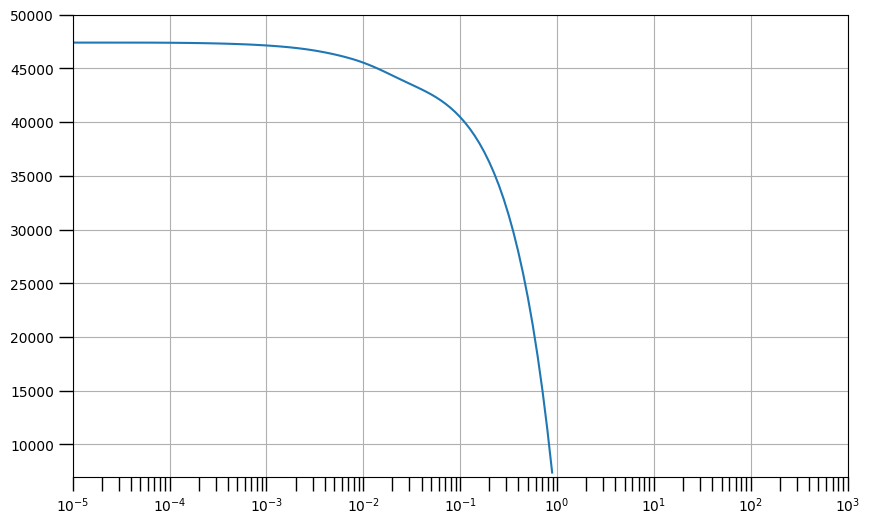

In [136]:
# # Define the learning rate array
lrs = 1e-5 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-5, 1e3, 7000, 50000])

## Train the Model Completely(for longer epoch)

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [137]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [138]:
# Initialize learning rate
lr = 1e-1

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=lr)


# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics='mae')

#callback
RLP = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    patience=3,
    verbose=2,
    mode="auto"
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=15,
    verbose=2,
    mode="auto",
    start_from_epoch=10
)

# Train the model
history = model.fit(train_set, epochs=500, validation_data=valid_set, verbose = 2, callbacks=[ES])

Epoch 1/500
35/35 - 16s - loss: 47397.4258 - mae: 47397.9258 - val_loss: 45898.5586 - val_mae: 45899.0547 - 16s/epoch - 467ms/step
Epoch 2/500
35/35 - 2s - loss: 47381.6133 - mae: 47382.1133 - val_loss: 45870.2852 - val_mae: 45870.7891 - 2s/epoch - 54ms/step
Epoch 3/500
35/35 - 2s - loss: 47347.4531 - mae: 47347.9609 - val_loss: 45835.7383 - val_mae: 45836.2422 - 2s/epoch - 53ms/step
Epoch 4/500
35/35 - 4s - loss: 47310.9961 - mae: 47311.5000 - val_loss: 45801.1016 - val_mae: 45801.6016 - 4s/epoch - 102ms/step
Epoch 5/500
35/35 - 2s - loss: 47275.7656 - mae: 47276.2656 - val_loss: 45768.3555 - val_mae: 45768.8555 - 2s/epoch - 56ms/step
Epoch 6/500
35/35 - 2s - loss: 47243.1328 - mae: 47243.6328 - val_loss: 45737.5430 - val_mae: 45738.0430 - 2s/epoch - 56ms/step
Epoch 7/500
35/35 - 2s - loss: 47211.4492 - mae: 47211.9453 - val_loss: 45707.3906 - val_mae: 45707.8945 - 2s/epoch - 55ms/step
Epoch 8/500
35/35 - 2s - loss: 47180.0391 - mae: 47180.5430 - val_loss: 45677.5742 - val_mae: 45678.

KeyboardInterrupt: 

## Visualize the model

In [145]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))


# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# print(int(epochs[-1]*0.2))
# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

KeyError: 'mae'

# Forcasting

In [ ]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    ds = ds.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(ds)

    return forecast

In [ ]:
# First Prediction
forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
print('Output shape:', forecast[0].shape)
print('First prediction: \n', forecast[0])

46/46 [==============================] - 3s 23ms/step
Output shape: (10, 48)
First prediction: 
 [[378.17963  340.14496  256.8232   456.31604  118.97477  127.18246
  102.55147  150.10385  343.15045  311.88693  230.96786  409.28235
  103.96593  110.83355   83.49701  139.72636  385.80298  342.72336
  253.44919  442.25787  120.58347  124.51919   86.41956  153.75758
  278.89444  277.48474  203.46852  363.13846   86.03055  104.05452
   74.56463  131.67972  113.81118  183.43126  104.67359  164.9763
   38.26609   84.98112   29.953667  70.037796 242.0154   239.42905
  183.91127  325.8863    76.937775 103.9725    76.59258  127.48905 ]
 [377.81946  340.83704  255.15012  455.08093  117.982925 126.58083
   90.3296   150.1972   341.5534   312.33267  230.52309  408.77728
  104.98352  113.63557   81.65039  139.72441  389.11447  342.18704
  252.0548   444.63525  121.46394  125.29582   87.95345  153.30496
  277.19394  277.19672  204.23004  362.08527   84.99791  105.61972
   68.14129  132.58937  111.911

# References

In [ ]:
# # This function downloads and extracts the dataset to the directory that contains this file.
# # DO NOT CHANGE THIS CODE
# # (unless you need to change the URL)
# def download_and_extract_data():
#     url = 'https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/household_power.zip'
#     urllib.request.urlretrieve(url, 'household_power.zip')
#     with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
#         zip_ref.extractall()


# # This function normalizes the dataset using min max scaling.
# # DO NOT CHANGE THIS CODE
# def normalize_series(data, min, max):
#     data = data - min
#     data = data / max
#     return data

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs = {}):
#     if(logs.get('loss') < 0.1):
#       print("\nDesired loss is achieved.")
#       self.model.stop_training = True

# # COMPLETE THE CODE IN THE FOLLOWING FUNCTION.
# def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
#     # YOUR CODE HERE
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
#     ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
#     return ds.batch(batch_size).prefetch(1)
#     # YOUR CODE HERE

# # COMPLETE THE CODE IN THE FOLLOWING FUNCTION.
# def solution_C5():
#     # Downloads and extracts the dataset to the directory that contains this file.
#     download_and_extract_data()
#     # Reads the dataset from the csv.
#     df = pd.read_csv('household_power_consumption.csv', sep=',',
#                      infer_datetime_format=True, index_col='datetime', header=0)

#     # Number of features in the dataset. We use all features as predictors to
#     # predict all features at future time steps.
#     N_FEATURES = len(df.columns) # YOUR CODE HERE

#     # Normalizes the data
#     # DO NOT CHANGE THIS
#     data = df.values
#     split_time = int(len(data) * 0.5)
#     data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    # # Splits the data into training and validation sets.
    # x_train = data[:split_time] # YOUR CODE HERE
    # x_valid = data[split_time:] # YOUR CODE HERE

    # # DO NOT CHANGE THIS
    # BATCH_SIZE = 32
    # N_PAST = 24 # Number of past time steps based on which future observations should be predicted
    # N_FUTURE = 24  # Number of future time steps which are to be predicted.
    # SHIFT = 1  # By how many positions the window slides to create a new window of observations.

    # # Code to create windowed train and validation datasets.
    # # Complete the code in windowed_dataset.
    # train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT) # YOUR CODE HERE
    # valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE, n_past=N_PAST, n_future=N_FUTURE, shift=SHIFT) # YOUR CODE HERE

    # Code to define your model.
    model = tf.keras.models.Sequential([
        # Whatever your first layer is, the input shape will be (N_PAST = 24, N_FEATURES = 7)
        # YOUR CODE HERE
        tf.keras.layers.Flatten(input_shape=(N_PAST, N_FEATURES)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(N_FUTURE * N_FEATURES),
        tf.keras.layers.Reshape([N_FUTURE, N_FEATURES]),
    ])

    # Code to train and compile the model
    # YOUR CODE HERE
    callback = myCallback()

    model.compile(
        loss = 'mae',
        optimizer = 'adam')

    num_epoch = 10

    model.fit(
        x=train_set,
        epochs = num_epoch,
        validation_data = valid_set,
        verbose=2,
        callbacks = callback)

    return model

In [ ]:
# The code below is to save your model as a .h5 file.
# It will be saved automatically in your Submission folder.
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = solution_C5()

Epoch 1/10

Desired loss is achieved.
1349/1349 - 24s - loss: 0.0738 - val_loss: 0.0607 - 24s/epoch - 18ms/step
